In [10]:
# --- Imports
import os, glob, math, time, json, random
from pathlib import Path

import numpy as np
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt

# Torch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# --- Reproducibility
SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device:", device)


Device: cuda


In [11]:
# Adjust these only if your paths changed
root = "/projectnb/ds340/projects/Fall_2025_Wrenn_Hear_Me_Out/kaggle/input"
ravdess = os.path.join(root, "ravdess-emotional-speech-audio", "audio_speech_actors_01-24")
cremad  = os.path.join(root, "cremad", "AudioWAV")
tess    = os.path.join(root, "toronto-emotional-speech-set-tess", "tess toronto emotional speech set data", "TESS Toronto emotional speech set data")
savee   = os.path.join(root, "surrey-audiovisual-expressed-emotion-savee", "ALL")

def list_wavs(root_dir):
    return sorted(glob.glob(os.path.join(root_dir, "**", "*.wav"), recursive=True))

def process_ravdess(root_dir):
    id2emo = {"01":"neutral","02":"neutral","03":"happy","04":"sad","05":"angry","06":"fear","07":"disgust","08":"surprise"}
    paths, emos = [], []
    for p in list_wavs(root_dir):
        parts = Path(p).stem.split("-")
        if len(parts) >= 3 and parts[2] in id2emo:
            paths.append(p); emos.append(id2emo[parts[2]])
    return pd.DataFrame({"Path": paths, "Emotions": emos})

def process_cremad(root_dir):
    map3 = {"SAD":"sad","ANG":"angry","DIS":"disgust","FEA":"fear","HAP":"happy","NEU":"neutral"}
    paths, emos = [], []
    for p in list_wavs(root_dir):
        parts = Path(p).stem.split("_")
        if len(parts) >= 3 and parts[2] in map3:
            paths.append(p); emos.append(map3[parts[2]])
    return pd.DataFrame({"Path": paths, "Emotions": emos})

def process_tess(root_dir):
    # e.g., OAF_back_angry.wav
    paths, emos = [], []
    for p in list_wavs(root_dir):
        head = Path(p).stem
        parts = head.split("_")
        if len(parts) >= 3:
            emo = parts[2]
            emo = "surprise" if emo == "ps" else emo
            paths.append(p); emos.append(emo)
    return pd.DataFrame({"Path": paths, "Emotions": emos})

def process_savee(root_dir):
    tag2emo = {"a":"angry","d":"disgust","f":"fear","h":"happy","n":"neutral","sa":"sad","su":"surprise"}
    paths, emos = [], []
    for p in list_wavs(root_dir):
        parts = Path(p).stem.split("_")
        if len(parts) >= 2:
            tag = parts[1]  # a01, sa01, su01...
            key = "sa" if tag.startswith("sa") else ("su" if tag.startswith("su") else tag[0])
            if key in tag2emo:
                paths.append(p); emos.append(tag2emo[key])
    return pd.DataFrame({"Path": paths, "Emotions": emos})

dfs = []
for name, f in [("RAVDESS", process_ravdess), ("CREMA-D", process_cremad),
                ("TESS", process_tess), ("SAVEE", process_savee)]:
    try:
        df = f(eval(name.lower().replace("-", "").replace(" ", "")))
        print(f"{name:8s}: {len(df):5d} files")
        dfs.append(df)
    except Exception as e:
        print(f"{name}: skipped ({e})")

data_df = pd.concat(dfs, ignore_index=True)
print("Total files:", len(data_df))
data_df.head()


RAVDESS :  2880 files
CREMA-D :  7442 files
TESS    :  5600 files
SAVEE   :   480 files
Total files: 16402


,Path,Emotions
0,/projectnb/ds340/projects/Fall_2025_Wrenn_Hear...,neutral
1,/projectnb/ds340/projects/Fall_2025_Wrenn_Hear...,neutral
2,/projectnb/ds340/projects/Fall_2025_Wrenn_Hear...,neutral
3,/projectnb/ds340/projects/Fall_2025_Wrenn_Hear...,neutral
4,/projectnb/ds340/projects/Fall_2025_Wrenn_Hear...,neutral


In [12]:
# Keep only the 4 emotions in the proposal
FOUR = {"angry","happy","neutral","sad"}  # proposal classes
mask = data_df["Emotions"].isin(FOUR)
data_df = data_df[mask].reset_index(drop=True)
print("Filtered to 4 emotions:", data_df["Emotions"].value_counts())


Filtered to 4 emotions: Emotions
neutral    2583
happy      2515
sad        2515
angry      2515
Name: count, dtype: int64


In [13]:
SR = 22050
DURATION = 2.5           # seconds (match what you used in MFCC)
HOP_LENGTH = 512
N_MELS = 128

# Compute target frame length for consistent tensors: T ≈ ceil((SR*DURATION)/HOP_LENGTH)
TARGET_FRAMES = int(math.ceil((SR * DURATION) / HOP_LENGTH))
print("TARGET_FRAMES:", TARGET_FRAMES)

def load_wav(path, sr=SR, duration=DURATION, offset=0.0):
    # offset can be >0 (you used ~0.6 in MFCCs), but we'll keep 0 here for full coverage
    y, sr = librosa.load(path, sr=sr, duration=duration, offset=0.0, mono=True)
    return y, sr

def to_mel_db(y, sr=SR, n_mels=N_MELS, hop_length=HOP_LENGTH):
    mel = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels, hop_length=hop_length)
    mel_db = librosa.power_to_db(mel, ref=np.max)
    return mel_db  # shape: (n_mels, T)

def pad_or_trim(mel_db, target_frames=TARGET_FRAMES):
    m, t = mel_db.shape
    if t == target_frames:
        return mel_db
    if t < target_frames:
        # pad with min value (very quiet background) to avoid mean shift
        pad_width = target_frames - t
        pad_vals = np.full((m, pad_width), mel_db.min(), dtype=mel_db.dtype)
        return np.hstack([mel_db, pad_vals])
    else:
        return mel_db[:, :target_frames]

def per_sample_standardize(x):
    # Standardize per-sample to zero mean, unit variance; guard against tiny std
    mu = x.mean()
    sigma = x.std()
    return (x - mu) / (sigma + 1e-6)


TARGET_FRAMES: 108


In [ ]:
# Optional: cache to speed up iterations
CACHE_FILE = "../cached_data/mel_data_cache.npz"

if os.path.exists(CACHE_FILE):
    cache = np.load(CACHE_FILE, allow_pickle=True)
    X_mel = cache["X"]
    y_labels = cache["y"]
    classes = list(cache["classes"])
    print("Loaded cached:", X_mel.shape, len(y_labels), classes)
else:
    # Encode labels
    le = LabelEncoder()
    y_labels = le.fit_transform(data_df["Emotions"].values)
    classes = list(le.classes_)
    print("Classes:", classes)

    # Build mel tensors
    X_list = []
    for i, p in enumerate(data_df["Path"].values):
        if (i+1) % 500 == 0:
            print(f"Processed {i+1}/{len(data_df)}")
        y, _ = load_wav(p)
        mel_db = to_mel_db(y)
        mel_db = pad_or_trim(mel_db, TARGET_FRAMES)
        mel_db = per_sample_standardize(mel_db)
        X_list.append(mel_db.astype(np.float32))

    X_mel = np.stack(X_list, axis=0)   # (N, 128, T)
    np.savez_compressed(CACHE_FILE, X=X_mel, y=y_labels, classes=np.array(classes, dtype=object))
    print("Saved cache:", CACHE_FILE, X_mel.shape)

# Add channel dim for Conv2d: (N, 1, 128, T)
X_mel = np.expand_dims(X_mel, axis=1)
X_mel.shape, len(y_labels), classes


Classes: ['angry', 'happy', 'neutral', 'sad']
Processed 500/10128
Processed 1000/10128
Processed 1500/10128
Processed 2000/10128
Processed 2500/10128
Processed 3000/10128
Processed 3500/10128
Processed 4000/10128
Processed 4500/10128
Processed 5000/10128
Processed 5500/10128
Processed 6000/10128
Processed 6500/10128
Processed 7000/10128
Processed 7500/10128
Processed 8000/10128
Processed 8500/10128
Processed 9000/10128
Processed 9500/10128
Processed 10000/10128
Saved cache: ./mel_data_cache.npz (10128, 128, 108)


((10128, 1, 128, 108), 10128, ['angry', 'happy', 'neutral', 'sad'])

In [ ]:
# Consistent split with your MFCC baseline random_state
X_train, X_test, y_train, y_test = train_test_split(
    X_mel, y_labels, test_size=0.2, random_state=42, shuffle=True, stratify=y_labels
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.15, random_state=42, shuffle=True, stratify=y_train
)

# ---- SpecAugment helpers (operate on (1, 128, T) torch tensors) ----
import torch.nn.functional as F
import random

def time_mask(x, T=20, num_masks=2):
    # x: (B, 1, 128, T)
    B, C, Freq, Time = x.shape
    for _ in range(num_masks):
        t = random.randint(0, min(T, max(1, Time//8)))
        t0 = random.randint(0, max(1, Time - t))
        x[..., t0:t0+t] = 0
    return x

def freq_mask(x, F=12, num_masks=2):
    B, C, Freq, Time = x.shape
    for _ in range(num_masks):
        f = random.randint(0, min(F, max(1, Freq//8)))
        f0 = random.randint(0, max(1, Freq - f))
        x[..., f0:f0+f, :] = 0
    return x

def maybe_noise(x, p=0.30, sigma=0.02):
    if random.random() < p:
        x = x + sigma*torch.randn_like(x)
    return x

def train_augment(x):
    # Apply SpecAugment + mild noise
    x = freq_mask(x, F=16, num_masks=2)
    x = time_mask(x, T=24, num_masks=2)
    x = maybe_noise(x, p=0.25, sigma=0.01)
    return x

# ---- Updated Dataset to apply aug only for training ----
class MelDataset(Dataset):
    def __init__(self, X, y, train=False):
        self.X = X
        self.y = y
        self.train = train
    def __len__(self): return len(self.y)
    def __getitem__(self, idx):
        x = torch.from_numpy(self.X[idx])  # (1, 128, T)
        if self.train:
            x = train_augment(x.unsqueeze(0)).squeeze(0)  # keep shape (1, 128, T)
        y = torch.tensor(self.y[idx], dtype=torch.long)
        return x, y

# Rebuild loaders with aug on train only
BATCH_SIZE = 32
train_loader = DataLoader(MelDataset(X_train, y_train, train=True),  batch_size=BATCH_SIZE, shuffle=True,  num_workers=2, pin_memory=True)
val_loader   = DataLoader(MelDataset(X_val,   y_val,   train=False), batch_size=128,       shuffle=False, num_workers=2, pin_memory=True)
test_loader  = DataLoader(MelDataset(X_test,  y_test,  train=False), batch_size=128,       shuffle=False, num_workers=2, pin_memory=True)


In [19]:
class MelCNN2D_BN(nn.Module):
    def __init__(self, n_mels=128, n_frames=128, n_classes=4):
        super().__init__()
        # 4 conv blocks with BN; wider but lightweight
        self.features = nn.Sequential(
            nn.Conv2d(1, 48, 3, padding=1), nn.BatchNorm2d(48), nn.ReLU(),
            nn.MaxPool2d(2),  # 64xT/2

            nn.Conv2d(48, 96, 3, padding=1), nn.BatchNorm2d(96), nn.ReLU(),
            nn.MaxPool2d(2),  # 32xT/4

            nn.Conv2d(96, 192, 3, padding=1), nn.BatchNorm2d(192), nn.ReLU(),
            nn.MaxPool2d(2),  # 16xT/8

            nn.Conv2d(192, 192, 3, padding=1), nn.BatchNorm2d(192), nn.ReLU(),
            nn.AdaptiveMaxPool2d((8, 8)),
            nn.Dropout(0.30),
        )
        with torch.no_grad():
            dummy = torch.zeros(1,1,n_mels,n_frames)
            flat = self.features(dummy).numel()
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(flat, 384), nn.ReLU(), nn.BatchNorm1d(384), nn.Dropout(0.35),
            nn.Linear(384, n_classes)
        )
    def forward(self, x): return self.classifier(self.features(x))

n_classes = len(np.unique(y_train))
model = MelCNN2D_BN(N_MELS, TARGET_FRAMES, n_classes).to(device)

# Label smoothing + weight decay tend to help with overconfident fits
criterion = nn.CrossEntropyLoss(label_smoothing=0.05)
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-3, weight_decay=1e-4)

# Cosine annealing works well for CNNs on audio
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20)


In [ ]:
EPOCHS = 40
EARLY_PATIENCE = 10
best_acc, epochs_no_improve = 0.0, 0
ckpt_path = "../models/mel_cnn2d_bn_best.pt"
history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

def run_epoch(loader, train=False):
    (model.train() if train else model.eval())
    total, correct, loss_sum = 0, 0, 0.0
    for xb, yb in loader:
        xb, yb = xb.to(device, non_blocking=True), yb.to(device, non_blocking=True)
        if train: optimizer.zero_grad()
        with torch.set_grad_enabled(train):
            logits = model(xb)
            loss = criterion(logits, yb)
            if train:
                loss.backward()
                optimizer.step()
        preds = logits.argmax(1)
        total += yb.size(0); correct += (preds == yb).sum().item()
        loss_sum += loss.item() * yb.size(0)
    return loss_sum/total, correct/total

for epoch in range(1, EPOCHS+1):
    tr_loss, tr_acc = run_epoch(train_loader, train=True)
    val_loss, val_acc = run_epoch(val_loader,   train=False)
    scheduler.step()

    history["train_loss"].append(tr_loss); history["train_acc"].append(tr_acc)
    history["val_loss"].append(val_loss);   history["val_acc"].append(val_acc)

    print(f"Epoch {epoch:02d}/{EPOCHS} | train_loss {tr_loss:.4f} acc {tr_acc:.4f} | val_loss {val_loss:.4f} acc {val_acc:.4f}")

    if val_acc > best_acc + 1e-4:
        best_acc = val_acc; epochs_no_improve = 0
        torch.save(model.state_dict(), ckpt_path)
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= EARLY_PATIENCE:
            print(f"Early stopping at epoch {epoch} (best {best_acc:.4f})")
            break

print("Best val_acc:", best_acc, "| saved:", ckpt_path)


Epoch 01/40 | train_loss 0.8983 acc 0.6509 | val_loss 2.1734 acc 0.4589
Epoch 02/40 | train_loss 0.7888 acc 0.7103 | val_loss 0.7185 acc 0.7418
Epoch 03/40 | train_loss 0.7449 acc 0.7387 | val_loss 1.0041 acc 0.6768
Epoch 04/40 | train_loss 0.7293 acc 0.7483 | val_loss 0.7114 acc 0.7730
Epoch 05/40 | train_loss 0.7236 acc 0.7447 | val_loss 0.7144 acc 0.7451
Epoch 06/40 | train_loss 0.6921 acc 0.7726 | val_loss 0.6883 acc 0.7903
Epoch 07/40 | train_loss 0.6620 acc 0.7848 | val_loss 0.7416 acc 0.7862
Epoch 08/40 | train_loss 0.6451 acc 0.7920 | val_loss 0.6623 acc 0.7936
Epoch 09/40 | train_loss 0.6308 acc 0.8009 | val_loss 0.7113 acc 0.7673
Epoch 10/40 | train_loss 0.6008 acc 0.8169 | val_loss 0.6603 acc 0.7870
Epoch 11/40 | train_loss 0.5835 acc 0.8270 | val_loss 0.6448 acc 0.8117
Epoch 12/40 | train_loss 0.5618 acc 0.8371 | val_loss 0.6314 acc 0.7952
Epoch 13/40 | train_loss 0.5340 acc 0.8510 | val_loss 0.5723 acc 0.8331
Epoch 14/40 | train_loss 0.5210 acc 0.8561 | val_loss 0.5580 acc

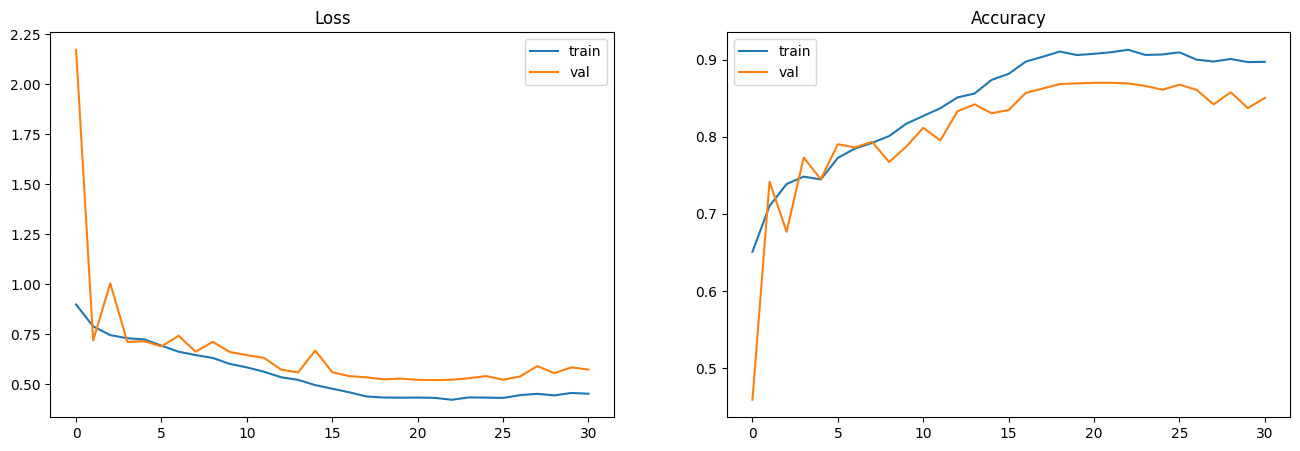

In [21]:
plt.figure(figsize=(16,5))
plt.subplot(1,2,1); plt.plot(history["train_loss"], label="train"); plt.plot(history["val_loss"], label="val"); plt.title("Loss"); plt.legend()
plt.subplot(1,2,2); plt.plot(history["train_acc"], label="train"); plt.plot(history["val_acc"], label="val"); plt.title("Accuracy"); plt.legend()
plt.show()


In [23]:
np.savez_compressed(
    "mel_baseline_results.npz",
    classes=np.array(classes, dtype=object),
    test_loss=test_loss,
    test_acc=test_acc,
    y_true=y_true,
    y_pred=y_pred,
)
print("Saved: mel_baseline_results.npz")


Saved: mel_baseline_results.npz
